In [1]:
import numpy as np
import pandas as pd
import os
from function import Slope, minSSE_recovery

s_c = '結算價'
top_path = './../../../'
Data_path = top_path + 'InterpData/'
expiry = 'NearbyMonth'

IV_type = 'callIV'
K_Range = [0, 800]
K_Range_file = '{}_{}.csv'.format(K_Range[0], K_Range[1])
K_Range_dir = '{}_{}'.format(K_Range[0], K_Range[1])
IV_path = '{}/{}/{}/{}'.format(Data_path, expiry, IV_type, K_Range_file)

Dir_tree = [top_path, 'ForecastData', expiry, IV_type, K_Range_dir]
current_path = Dir_tree[0]
for i in range(1, len(Dir_tree), 1):
    if Dir_tree[i] not in os.listdir(current_path):
        os.mkdir(current_path + Dir_tree[i])
    current_path = current_path + Dir_tree[i] + '/'

IV_data = pd.read_csv(IV_path, encoding='Big5', index_col=False)
IV_matrix = np.array(IV_data)

#----------------------------------------------------------------------------


OC = np.array(IV_data['期貨開盤價'] - IV_data['期貨收盤價'])
HL = np.array(IV_data['期貨最高價'] - IV_data['期貨最低價'])
expirty_days = np.array(IV_data['到期天數'])
#OC_HL_K_E = np.vstack((OC, HL, Kmin_reduce_F, Kmax_reduce_F, expirty_days)).T
OCHL = np.vstack((OC, HL)).T


IV_matrix = np.array(IV_data)
K_num = len(np.where(IV_matrix[0, 0] == IV_matrix)[0])
K = np.array(IV_data['履約價'])
K = np.reshape(K, (-1, K_num))
IV= np.array(IV_data['隱含波動率({})'.format(s_c)])
IV = np.reshape(IV, (-1, K_num))
K_IVslope = Slope(X=K, Y=IV, axis=1)
E = IV_matrix[range(0, len(IV_matrix), K_num), IV_data.columns.get_loc('到期天數')]



In [2]:
one_day_expiry_idx = np.arange(len(E))[np.equal(E, 1)]
if one_day_expiry_idx[-1] == len(E)-1:
    one_day_expiry_idx = one_day_expiry_idx[:-1]
most_days_expiry_idx = one_day_expiry_idx + 1
most_days_expiry_idx = np.hstack((0, most_days_expiry_idx))

most_days_expiry_idx0 = most_days_expiry_idx[:-1]
most_days_expiry_idx1 = most_days_expiry_idx[1:]
trade_days_in_month = most_days_expiry_idx1 - most_days_expiry_idx0  
most_days_expiry = E[most_days_expiry_idx]

contract_appear_days1 = [list(range(1, trade_day_in_month+1, 1)) \
                for trade_day_in_month in trade_days_in_month]
contract_appear_days1 = [contract_appear_day1 for subcontract_appear_day1 in contract_appear_days1\
                         for contract_appear_day1 in subcontract_appear_day1]
contract_appear_days1 = np.array(contract_appear_days1)
contract_appear_days2 = np.arange(1, len(E) - most_days_expiry_idx[-1] +1, 1)
contract_appear_days = np.hstack((contract_appear_days1, contract_appear_days2))
#contract_appear_days 為該契約(特定交易日期、到期日期，履約價不限)上市的交易日數，例如第一天上市到期天數35天，
#則值為1，第二天則到期日為34天值為2，一直到k(因為是交易日數，所以數字不一定)。然後又到下個月的契約，值又從1開
#始


from function import TimeSeriesData
seq_length1 = 7
seq_length2 = seq_length1 + 1
min_contract_day = 2
magnification_slope = 10000



K_IVslope_E = np.hstack((K_IVslope*magnification_slope, np.reshape(E, (-1, 1))))
#K_IVslope_E = K_IVslope * magnification_slope
Inputs_slope, Ouputs = TimeSeriesData(K_IVslope_E, seq_length=seq_length1, \
                                      drop_out_columns=[len(K_IVslope_E[0])-1])


Inputs_OCHLE  = OCHL[range(0, len(IV_matrix), K_num)]
Inputs_OCHLE  = np.array([Inputs_OCHLE[i:i+seq_length2] \
                              for i in range(len(Inputs_OCHLE)-seq_length2+1)])
Inputs_OCHLE  = Inputs_OCHLE.astype(float)
if seq_length1  > seq_length2-1:
    Inputs_OCHLE = Inputs_OCHLE[seq_length1-seq_length2+1:]
    contract_appear_days = contract_appear_days[seq_length1-seq_length2+1:]
    IV_matrix_forecast = IV_matrix[seq_length1*K_num:]
if seq_length1 <= seq_length2-1:
    Inputs_slope = Inputs_slope[seq_length2-1-seq_length1:]
    Ouputs = Ouputs[seq_length2-1-seq_length1:]
    contract_appear_days = contract_appear_days[seq_length2-1:]
    IV_matrix_forecast = IV_matrix[(seq_length2-1)*K_num:]


match_cond = np.greater_equal(contract_appear_days, min_contract_day)
Inputs_OCHLE = Inputs_OCHLE[match_cond]
Inputs_slope = Inputs_slope[match_cond]
contract_appear_days_filter = contract_appear_days[match_cond]
contract_appear_days_filter_Knum = contract_appear_days_filter.repeat(K_num)
match_cond_Knum = match_cond.repeat(K_num)
IV_matrix_forecast = IV_matrix_forecast[match_cond_Knum]
IV_matrix_forecast= np.hstack((IV_matrix_forecast, np.reshape(contract_appear_days_filter_Knum, (-1, 1))))
Ouputs = Ouputs[match_cond]



train_size = int(len(Inputs_slope)*0.8)
#val_size = int(train_size*0.2)
X_train = Inputs_slope[:train_size]
#X_train = Inputs_slope[:train_size-val_size]
#X_val = Inputs_slope[train_size - val_size:train_size]
OCHLE_train = Inputs_OCHLE[:train_size ]
#OCHLE_train = Inputs_OCHLE[:train_size - val_size]
#OCHLE_val = Inputs_OCHLE[train_size - val_size:train_size]
y_train = Ouputs[:train_size]
#y_train = Ouputs[:train_size-val_size]
#y_val = Ouputs[train_size - val_size:train_size]


X_test = Inputs_slope[train_size:]
y_test = Ouputs[train_size:]
IV_matrix_test = IV_matrix_forecast[K_num*train_size:]
OCHLE_test = Inputs_OCHLE[train_size:]


In [3]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, concatenate
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
#此函示可以幫我們設定一個模型的結構
def set_LSTM_LSTM(lstm1_structure, lstm2_structure, Megred_struture):
    lstm1_neurons_num = lstm1_structure['lstm_neurons_num']
    lstm1_activations = lstm1_structure['lstm_activations']
    lstm1_recurrent_activations = lstm1_structure['lstm_recurrent_activations']
    dense1_neurons_num = lstm1_structure['dense_neurons_num']
    dense1_activations = lstm1_structure['dense_activations']
    kernel_regularizer1= lstm1_structure['kernel_regularizer']

    lstm2_neurons_num = lstm2_structure['lstm_neurons_num']
    lstm2_activations = lstm2_structure['lstm_activations']
    lstm2_recurrent_activations = lstm2_structure['lstm_recurrent_activations']
    dense2_neurons_num = lstm2_structure['dense_neurons_num']
    dense2_activations = lstm2_structure['dense_activations']
    kernel_regularizer2= lstm2_structure['kernel_regularizer']
    
    Merged_neurons_num = Megred_struture['neurons_num']
    Megred_activations = Megred_struture['activations']
    Merged_kernel_regularizer = Megred_struture['kernel_regularizer']

    input_lstm1 = Input(shape=lstm1_structure['input_shape'])
    hidden_1 = input_lstm1

    for i in range(0, len(lstm1_neurons_num), 1):
        if i == len(lstm1_neurons_num) - 1:
            return_sequences=False
        else:
            return_sequences=True 
        hidden_1 = LSTM(lstm1_neurons_num[i], return_sequences=return_sequences,\
        activation=lstm1_activations[i], kernel_regularizer=kernel_regularizer1[i],
        recurrent_activation= lstm1_recurrent_activations[i])(hidden_1)
    output_1 = hidden_1
    for i in range(0, len(dense1_neurons_num), 1):
        output_1 = Dense(dense1_neurons_num[i], \
            kernel_regularizer=kernel_regularizer1[len(lstm1_neurons_num)-1+i], \
            activation=dense1_activations[i])(output_1)
        
    input_lstm2 = Input(shape=lstm2_structure['input_shape'])
    hidden_2 = input_lstm2

    for i in range(0, len(lstm2_neurons_num), 1):
        if i == len(lstm2_neurons_num) - 1:
            return_sequences=False
        else:
            return_sequences=True 
        hidden_2 = LSTM(lstm2_neurons_num[i], return_sequences=return_sequences,\
        activation=lstm2_activations[i], kernel_regularizer=kernel_regularizer2[i],
        recurrent_activation= lstm2_recurrent_activations[i])(hidden_2)
    output_2 = hidden_2
    for i in range(0, len(dense2_neurons_num), 2):
        output_2 = Dense(dense2_neurons_num[i], \
            kernel_regularizer=kernel_regularizer2[len(lstm2_neurons_num)-1+i], \
            activation=dense2_activations[i])(output_2)
        
    merged = concatenate([output_1, output_2], axis=-1)
    dense = merged
    for i in range(len(Merged_neurons_num)):
        dense = Dense(Merged_neurons_num[i], Megred_activations[i], Merged_kernel_regularizer[i])(dense)

    output = Dense(y_train.shape[1])(dense)
    model = Model(inputs=[input_lstm1, input_lstm2], outputs=output)
    return model






#決定這次的模型編號
model_idx = 1
#本次預測的變數為：slope(隱波與履約價之間的斜率)或iv(隱波的數值)
forecast_variable = 'slope'
#資料設定都相同的情況下，最多儲存多少種模型結果
max_model = 20

#設定參數
lambda1 = 0.01
lambda2 = 0.01
lambda3 = 0.01
batch_size = 500
epochs = 1000

OCHL_lstm_neurons_num = [600, 600, 600]
OCHLE_lstm_activations = ['tanh']*len(OCHL_lstm_neurons_num)
OCHL_lstm_recurrent_activations = ['sigmoid']*len(OCHL_lstm_neurons_num)
OCHL_dense_neurons_num = [600]
OCHL_dense_activations = ['relu']
OCHL_kernel_regularizer=[l2(lambda1)]*(len(OCHL_lstm_neurons_num) + len(OCHL_dense_neurons_num))

Slope_lstm_layers_num = 2
Slope_lstm_neurons_num = [600, 600, 600]
Slope_lstm_activations = ['tanh']*len(Slope_lstm_neurons_num)
Slope_lstm_recurrent_activations = ['sigmoid']*len(Slope_lstm_neurons_num)
Slope_dense_neurons_num = [600]
Slope_dense_activations = ['relu']
Slope_kernel_regularizer=[l2(lambda2)]*(len(Slope_lstm_neurons_num) + len(Slope_dense_neurons_num))

Merged_neurons_num = [600, 600]
Megred_activations = ['relu']*len(Merged_neurons_num)
Merged_kernel_regularizer=[l2(lambda3)]*(len(Merged_neurons_num))

lstm_OCHL_structure = {
    'input_shape': OCHLE_train.shape[1:],
    'lstm_neurons_num': OCHL_lstm_neurons_num,
    'lstm_activations': OCHLE_lstm_activations,
    'lstm_recurrent_activations':OCHL_lstm_recurrent_activations,
    'dense_neurons_num':OCHL_dense_neurons_num,
    'dense_activations':OCHL_dense_activations,
    'kernel_regularizer':OCHL_kernel_regularizer
}

lstm_Slope_structure = {
    'input_shape': X_train.shape[1:],
    'lstm_neurons_num': Slope_lstm_neurons_num,
    'lstm_activations': Slope_lstm_activations,
    'lstm_recurrent_activations':Slope_lstm_recurrent_activations,
    'dense_neurons_num':Slope_dense_neurons_num,
    'dense_activations':Slope_dense_activations,
    'kernel_regularizer':Slope_kernel_regularizer
}

Merged_structure = {
    'neurons_num': Merged_neurons_num,
    'activations': Megred_activations,
    'kernel_regularizer': Merged_kernel_regularizer
}

alltrain = 3
allMSE = np.zeros(alltrain) 
allForecastIV = np.zeros((K_num*len(OCHLE_test), 3))
allSSE_everyday = np.zeros((K_num*len(OCHLE_test), 3))
allSSE_everyday_adj = np.zeros((K_num*len(OCHLE_test), 3))
for j in range(alltrain):
    #設定模型結構
    model = set_LSTM_LSTM(lstm_OCHL_structure, lstm_Slope_structure, Merged_structure)
    model.compile(loss='mse', optimizer = 'adam', metrics=['mse'])  

    # 訓練模型
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, \
                               verbose=2, mode='min', restore_best_weights=True)
    hist_model = model.fit(
        [OCHLE_train, X_train], y_train, epochs=epochs, batch_size=batch_size, \
        validation_split=0.2, callbacks=[early_stopping]
    )




    #得到輸出
    y_pred = model.predict([OCHLE_test, X_test])
    y_pred = y_pred / magnification_slope
    columns_names = ['履約價', '隱含波動率({})'.format(s_c)]
    column_index = [IV_data.columns.get_loc(col) for col in columns_names]
    ForecastIV = np.zeros(((len(y_pred), K_num)))
    SSE_everyday = np.zeros(((len(y_pred), K_num)))
    SSE_everyday_adj = np.zeros(((len(y_pred), K_num)))

    model_name = 'model{}'.format(model_idx)
    model_file = 'model{}.h5'.format(model_idx)
    model_png = 'model{}.png'.format(model_idx)
    Forecast_name = 'model{}.csv'.format(model_idx)
    
    for i in range(len(y_pred)):
        K_day = IV_matrix_test[i*K_num:(i+1)*K_num, column_index[0]]
        iv_day = IV_matrix_test[i*K_num:(i+1)*K_num, column_index[1]]
        y_pred_day = y_pred[i]
        iv_day_std = iv_day / np.std(iv_day, ddof=1)
        y_pred_day_adj = y_pred_day / np.std(iv_day, ddof=1)
        ForecastIV[i], SSE_everyday[i] = minSSE_recovery(y=iv_day, x=K_day, slope_yhat=y_pred_day)
        ForecastIV_day_adj, SSE_everyday_adj[i] = minSSE_recovery(y=iv_day_std, x=K_day, slope_yhat=y_pred_day_adj)


    ForecastIV = np.reshape(ForecastIV,(-1,1))
    sse_everyday = SSE_everyday[:, 0]
    sse_everyday_adj = SSE_everyday_adj[:, 0]
    SSE_everyday = np.reshape(SSE_everyday ,(-1,1))
    SSE_everyday_adj = np.reshape(SSE_everyday_adj ,(-1,1))
    allMSE[j] = np.mean(sse_everyday)
    allForecastIV[:,j:j+1] = ForecastIV
    allSSE_everyday[:, j:j+1] = SSE_everyday
    allSSE_everyday_adj[:, j:j+1] = SSE_everyday_adj

min_MSE_idx = np.argsort(allMSE)[0]
ForecastIV = allForecastIV[:, min_MSE_idx:min_MSE_idx+1]
allSSE_everyday = allSSE_everyday[:, min_MSE_idx:min_MSE_idx+1]
allSSE_everyday_adj = allSSE_everyday_adj[:, min_MSE_idx:min_MSE_idx+1]
min_MSE = allMSE[min_MSE_idx]

Forecast_matrix  = np.hstack((IV_matrix_test, ForecastIV, SSE_everyday, SSE_everyday_adj))
column = np.hstack((IV_data.columns.to_numpy(), \
                        np.array(['上市天數(交易日)','預測隱含波動率({})'.format(s_c), 'loss', '調整後loss'])))
    
   
Forecast_Data = pd.DataFrame(data=Forecast_matrix, columns=column)


loss_columns_names = ['交易日期', '到期天數', '上市天數(交易日)', 'loss']
loss_columns_index = [Forecast_Data.columns.get_loc(col) for col in loss_columns_names]
loss_Data = Forecast_Data.iloc[range(0, len(Forecast_Data), K_num), loss_columns_index]
loss_Data = loss_Data.reset_index().iloc[:,1:]
loss_Data = loss_Data.rename(columns={'loss': model_name})
MSE_data = pd.DataFrame(columns=loss_Data.columns, data=[['MSE', 'MSE', 'MSE', min_MSE]])
loss_Data = pd.concat([loss_Data, MSE_data], axis=0)
loss_Data = loss_Data.reset_index().iloc[:,1:]
print(min_MSE)




model_path = top_path
model_type = 'LSTM-LSTM'

model_Dir_tree = ['Forecast&model', expiry, IV_type, 'K_{}'.format(K_Range_dir), \
                  'seq{}_min{}'.format(seq_length1, seq_length2), model_type, forecast_variable]
for model_dir in model_Dir_tree:
    if model_dir not in os.listdir(model_path):
        os.mkdir(model_path + model_dir)
    model_path = model_path + model_dir + '/'

loss_adj_columns_names = ['交易日期', '到期天數', '調整後loss']
loss_adj_columns_index = [Forecast_Data.columns.get_loc(col) for col in loss_adj_columns_names]
loss_adj_Data = Forecast_Data.iloc[range(0, len(Forecast_Data), K_num), loss_adj_columns_index]
loss_adj_Data = loss_adj_Data.reset_index().iloc[:,1:]
loss_adj_Data = loss_adj_Data.rename(columns={'調整後loss': model_name})
MSE_adj_data = pd.DataFrame(columns=loss_adj_Data.columns, data=[['MSE', 'MSE', np.mean(sse_everyday_adj)]])
loss_adj_Data = pd.concat([loss_adj_Data, MSE_adj_data], axis=0)
loss_adj_Data = loss_adj_Data.reset_index().iloc[:,1:]



if 'Modelloss.csv' in os.listdir(model_path):
    Modelloss = pd.read_csv(model_path + 'Modelloss.csv', index_col=False, encoding='Big5')
    Modelloss_adj = pd.read_csv(model_path + 'Modelloss_adj.csv', index_col=False, encoding='Big5')
    if model_name in Modelloss.columns:
        if Modelloss[model_name][len(Modelloss)-1] > np.mean(sse_everyday):
            Modelloss[model_name] = loss_Data[model_name]
            Modelloss_adj[model_name] = loss_adj_Data[model_name]
            Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
            model.save(model_path + model_file)
            plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)
            print('原本的{}已經被替換'.format(model_name))
        else:
            print('此模型未被儲存')
    elif len(Modelloss.columns) >= max_model+2 :
        all_MSE = np.array(Modelloss.iloc[-1, 2:])
        max_MSE = np.max(all_MSE)
        if max_MSE > np.mean(sse_everyday):
            max_MSE_idx = (np.arange(len(all_MSE))[np.equal(all_MSE, max_MSE)])[0] +2
            Modelloss.iloc[:,max_MSE_idx] = loss_Data[model_name]
            Modelloss_adj.iloc[:,max_MSE_idx] = loss_adj_Data[model_name]
            model_name = Modelloss.columns[max_MSE_idx]
            Forecast_name = model_name + '.csv'
            model_file = model_name + '.h5'
            model_png = model_name + '.png'
            Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
            model.save(model_path + model_file)
            plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)
            print('原本的{}已經被替換'.format(model_name))
        else:
            print('此模型未被儲存')
    else:
        Modelloss = pd.concat([Modelloss, loss_Data[model_name]], axis=1)
        Modelloss = Modelloss.reset_index().iloc[:,1:] 
        Modelloss_adj = pd.concat([Modelloss_adj, loss_Data[model_name]], axis=1)
        Modelloss_adj = Modelloss_adj.reset_index().iloc[:,1:] 
        Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
        model.save(model_path + model_file)
        plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)
        print('此模型已經被儲存為{}'.format(model_name))
else:
    Modelloss = loss_Data
    Modelloss_adj = loss_adj_Data
    Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
    model.save(model_path + model_file)
    plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)

    
Modelloss.to_csv(model_path + 'Modelloss.csv', index=False, encoding='Big5')
Modelloss_adj.to_csv(model_path + 'Modelloss_adj.csv', index=False, encoding='Big5')


Epoch 1/1000
4/4 [==============================] - 8s 545ms/step - loss: 51.1212 - mse: 2.7021 - val_loss: 42.3634 - val_mse: 1.2899
Epoch 2/1000
4/4 [==============================] - 0s 93ms/step - loss: 40.0881 - mse: 2.1522 - val_loss: 33.5774 - val_mse: 1.6116
Epoch 3/1000
4/4 [==============================] - 0s 95ms/step - loss: 31.3997 - mse: 2.0272 - val_loss: 25.6836 - val_mse: 1.1902
Epoch 4/1000
4/4 [==============================] - 0s 95ms/step - loss: 24.0564 - mse: 1.6297 - val_loss: 19.5940 - val_mse: 1.0297
Epoch 5/1000
4/4 [==============================] - 0s 95ms/step - loss: 18.1912 - mse: 1.2484 - val_loss: 15.0542 - val_mse: 1.1270
Epoch 6/1000
4/4 [==============================] - 0s 94ms/step - loss: 13.6508 - mse: 0.9775 - val_loss: 11.7927 - val_mse: 1.4283
Epoch 7/1000
4/4 [==============================] - 0s 95ms/step - loss: 10.4795 - mse: 1.0507 - val_loss: 8.5210 - val_mse: 0.7912
Epoch 8/1000
4/4 [==============================] - 0s 97ms/step - lo

In [4]:
model_path = top_path

model_Dir_tree = ['Forecast&model', expiry, IV_type, 'K_{}'.format(K_Range_dir), \
                  'days_{}_{}'.format(seq_length1, seq_length2), model_type, forecast_variable]
for model_dir in model_Dir_tree:
    if model_dir not in os.listdir(model_path):
        os.mkdir(model_path + model_dir)
    model_path = model_path + model_dir + '/'


#while 'model{}.h5'.format(model_idx) in os.listdir(model_path):
    #model_idx + model_idx + 1
model_name = 'model{}'.format(model_idx)
model_file = 'model{}.h5'.format(model_idx)
model_png = 'model{}.png'.format(model_idx)
Forecast_name = 'model{}.csv'.format(model_idx)

#models = os.listdir
#test_loss = model.evaluate([OCHLE_test, X_test], y_test)
#print("Test Loss:", test_loss)
# 查看測試輸出
y_pred = model.predict([OCHLE_test, X_test])
y_pred = y_pred / magnification_slope
columns_names = ['履約價', '隱含波動率({})'.format(s_c)]
column_index = [IV_data.columns.get_loc(col) for col in columns_names]
ForecastIV = np.zeros(((len(y_pred), K_num)))
SSE_everyday = np.zeros(((len(y_pred), K_num)))
SSE_everyday_adj = np.zeros(((len(y_pred), K_num)))


for i in range(len(y_pred)):
    K_day = IV_matrix_test[i*K_num:(i+1)*K_num, column_index[0]]
    iv_day = IV_matrix_test[i*K_num:(i+1)*K_num, column_index[1]]
    y_pred_day = y_pred[i]
    iv_day_std = iv_day / np.std(iv_day, ddof=1)
    y_pred_day_adj = y_pred_day / np.std(iv_day, ddof=1)
    ForecastIV[i], SSE_everyday[i] = minSSE_recovery(y=iv_day, x=K_day, slope_yhat=y_pred_day)
    ForecastIV_day_adj, SSE_everyday_adj[i] = minSSE_recovery(y=iv_day_std, x=K_day, slope_yhat=y_pred_day_adj)
    

ForecastIV = np.reshape(ForecastIV,(-1,1))
sse_everyday = SSE_everyday[:, 0]
sse_everyday_adj = SSE_everyday_adj[:, 0]
SSE_everyday = np.reshape(SSE_everyday ,(-1,1))
SSE_everyday_adj = np.reshape(SSE_everyday_adj ,(-1,1))
Forecast_matrix  = np.hstack((IV_matrix_test, ForecastIV, SSE_everyday, SSE_everyday_adj))
column = np.hstack((IV_data.columns.to_numpy(), np.array(['預測隱含波動率({})'.format(s_c), 'loss', '調整後loss'])))
Forecast_Data = pd.DataFrame(data=Forecast_matrix, columns=column)


loss_columns_names = ['交易日期', '到期天數', 'loss']
loss_columns_index = [Forecast_Data.columns.get_loc(col) for col in loss_columns_names]
loss_Data = Forecast_Data.iloc[range(0, len(Forecast_Data), K_num), loss_columns_index]
loss_Data = loss_Data.reset_index().iloc[:,1:]
loss_Data = loss_Data.rename(columns={'loss': model_name})
MSE_data = pd.DataFrame(columns=loss_Data.columns, data=[['MSE', 'MSE', np.mean(sse_everyday)]])
loss_Data = pd.concat([loss_Data, MSE_data], axis=0)
loss_Data = loss_Data.reset_index().iloc[:,1:]
print(np.mean(sse_everyday))

#-----------------------------------------------

loss_adj_columns_names = ['交易日期', '到期天數', '調整後loss']
loss_adj_columns_index = [Forecast_Data.columns.get_loc(col) for col in loss_adj_columns_names]
loss_adj_Data = Forecast_Data.iloc[range(0, len(Forecast_Data), K_num), loss_adj_columns_index]
loss_adj_Data = loss_adj_Data.reset_index().iloc[:,1:]
loss_adj_Data = loss_adj_Data.rename(columns={'調整後loss': model_name})
MSE_adj_data = pd.DataFrame(columns=loss_adj_Data.columns, data=[['MSE', 'MSE', np.mean(sse_everyday_adj)]])
loss_adj_Data = pd.concat([loss_adj_Data, MSE_adj_data], axis=0)
loss_adj_Data = loss_adj_Data.reset_index().iloc[:,1:]


from tensorflow.keras.utils import plot_model
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

if 'Modelloss.csv' in os.listdir(model_path):
    Modelloss = pd.read_csv(model_path + 'Modelloss.csv', index_col=False, encoding='Big5')
    Modelloss_adj = pd.read_csv(model_path + 'Modelloss_adj.csv', index_col=False, encoding='Big5')
    if model_name in Modelloss.columns:
        if Modelloss[model_name][len(Modelloss)-1] > np.mean(sse_everyday):
            Modelloss[model_name] = loss_Data[model_name]
            Modelloss_adj[model_name] = loss_adj_Data[model_name]
            Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
            model.save(model_path + model_file)
            plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)
            print('原本的{}已經被替換'.format(model_name))
        else:
            print('此模型未被儲存')
    elif len(Modelloss.columns) >= 22 :
        all_MSE = np.array(Modelloss.iloc[-1, 2:])
        max_MSE = np.max(all_MSE)
        if max_MSE > np.mean(sse_everyday):
            max_MSE_idx = (np.arange(len(all_MSE))[np.equal(all_MSE, max_MSE)])[0] +2
            Modelloss.iloc[:,max_MSE_idx] = loss_Data[model_name]
            Modelloss_adj.iloc[:,max_MSE_idx] = loss_adj_Data[model_name]
            model_name = Modelloss.columns[max_MSE_idx]
            Forecast_name = model_name + '.csv'
            model_file = model_name + '.h5'
            model_png = model_name + '.png'
            Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
            model.save(model_path + model_file)
            plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)
            print('原本的{}已經被替換'.format(model_name))
        else:
            print('此模型未被儲存')
    else:
        Modelloss = pd.concat([Modelloss, loss_Data[model_name]], axis=1)
        Modelloss = Modelloss.reset_index().iloc[:,1:] 
        Modelloss_adj = pd.concat([Modelloss_adj, loss_Data[model_name]], axis=1)
        Modelloss_adj = Modelloss_adj.reset_index().iloc[:,1:] 
        Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
        model.save(model_path + model_file)
        plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)
        print('此模型已經被儲存為{}'.format(model_name))
else:
    Modelloss = loss_Data
    Modelloss_adj = loss_adj_Data
    Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
    model.save(model_path + model_file)
    plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)

    
Modelloss.to_csv(model_path + 'Modelloss.csv', index=False, encoding='Big5')
Modelloss_adj.to_csv(model_path + 'Modelloss_adj.csv', index=False, encoding='Big5')

18/18 [==============================] - 0s 19ms/step


ValueError: Shape of passed values is (55900, 15), indices imply (55900, 14)

In [15]:
model_idx = 1
y_pred = model.predict([OCHLE_test, X_test])
y_pred = y_pred / magnification_slope
columns_names = ['履約價', '隱含波動率({})'.format(s_c)]
column_index = [IV_data.columns.get_loc(col) for col in columns_names]
ForecastIV = np.zeros(((len(y_pred), K_num)))
SSE_everyday = np.zeros(((len(y_pred), K_num)))
SSE_everyday_adj = np.zeros(((len(y_pred), K_num)))

model_name = 'model{}'.format(model_idx)
model_file = 'model{}.h5'.format(model_idx)
model_png = 'model{}.png'.format(model_idx)
Forecast_name = 'model{}.csv'.format(model_idx)
for i in range(len(y_pred)):
    K_day = IV_matrix_test[i*K_num:(i+1)*K_num, column_index[0]]
    iv_day = IV_matrix_test[i*K_num:(i+1)*K_num, column_index[1]]
    y_pred_day = y_pred[i]
    iv_day_std = iv_day / np.std(iv_day, ddof=1)
    y_pred_day_adj = y_pred_day / np.std(iv_day, ddof=1)
    ForecastIV[i], SSE_everyday[i] = minSSE_recovery(y=iv_day, x=K_day, slope_yhat=y_pred_day)
    ForecastIV_day_adj, SSE_everyday_adj[i] = minSSE_recovery(y=iv_day_std, x=K_day, slope_yhat=y_pred_day_adj)
    

ForecastIV = np.reshape(ForecastIV,(-1,1))
sse_everyday = SSE_everyday[:, 0]
sse_everyday_adj = SSE_everyday_adj[:, 0]
SSE_everyday = np.reshape(SSE_everyday ,(-1,1))
SSE_everyday_adj = np.reshape(SSE_everyday_adj ,(-1,1))
Forecast_matrix  = np.hstack((IV_matrix_test, ForecastIV, SSE_everyday, SSE_everyday_adj))
column = np.hstack((IV_data.columns.to_numpy(), np.array(['預測隱含波動率({})'.format(s_c), 'loss', '調整後loss'])))
Forecast_Data = pd.DataFrame(data=Forecast_matrix, columns=column)


loss_columns_names = ['交易日期', '到期天數', 'loss']
loss_columns_index = [Forecast_Data.columns.get_loc(col) for col in loss_columns_names]
loss_Data = Forecast_Data.iloc[range(0, len(Forecast_Data), K_num), loss_columns_index]
loss_Data = loss_Data.reset_index().iloc[:,1:]
loss_Data = loss_Data.rename(columns={'loss': model_name})
MSE_data = pd.DataFrame(columns=loss_Data.columns, data=[['MSE', 'MSE', np.mean(sse_everyday)]])
loss_Data = pd.concat([loss_Data, MSE_data], axis=0)
loss_Data = loss_Data.reset_index().iloc[:,1:]
print(np.mean(sse_everyday))

19/19 [==============================] - 2s 19ms/step
0.007895605823034531


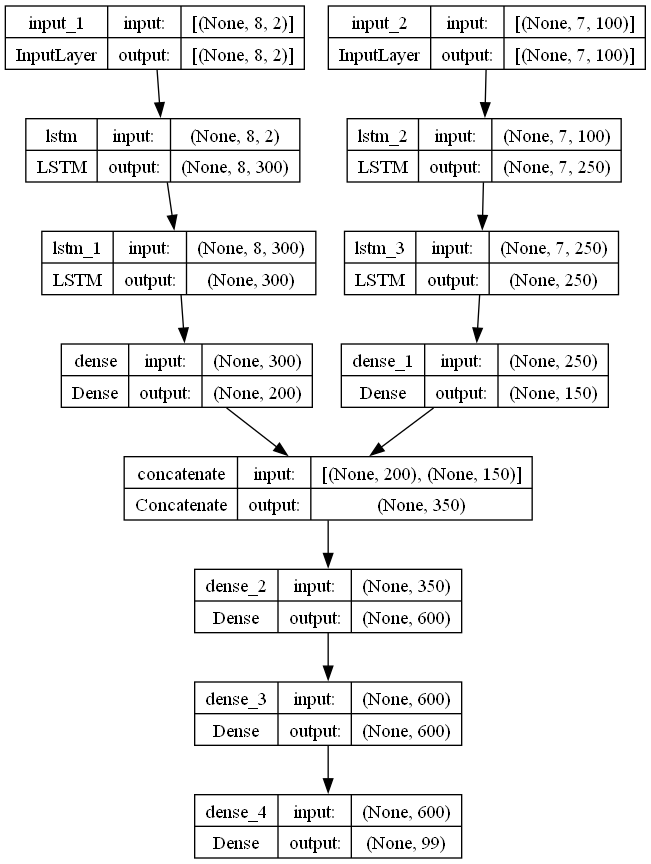

In [3]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, concatenate
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
def set_LSTM_LSTM(lstm1_structure, lstm2_structure, Megred_struture):
    lstm1_neurons_num = lstm1_structure['lstm_neurons_num']
    lstm1_activations = lstm1_structure['lstm_activations']
    lstm1_recurrent_activations = lstm1_structure['lstm_recurrent_activations']
    dense1_neurons_num = lstm1_structure['dense_neurons_num']
    dense1_activations = lstm1_structure['dense_activations']
    kernel_regularizer1= lstm1_structure['kernel_regularizer']

    lstm2_neurons_num = lstm2_structure['lstm_neurons_num']
    lstm2_activations = lstm2_structure['lstm_activations']
    lstm2_recurrent_activations = lstm2_structure['lstm_recurrent_activations']
    dense2_neurons_num = lstm2_structure['dense_neurons_num']
    dense2_activations = lstm2_structure['dense_activations']
    kernel_regularizer2= lstm2_structure['kernel_regularizer']
    
    Merged_neurons_num = Megred_struture['neurons_num']
    Megred_activations = Megred_struture['activations']
    Merged_kernel_regularizer = Megred_struture['kernel_regularizer']

    input_lstm1 = Input(shape=lstm1_structure['input_shape'])
    hidden_1 = input_lstm1

    for i in range(0, len(lstm1_neurons_num), 1):
        if i == len(lstm1_neurons_num) - 1:
            return_sequences=False
        else:
            return_sequences=True 
        hidden_1 = LSTM(lstm1_neurons_num[i], return_sequences=return_sequences,\
        activation=lstm1_activations[i], kernel_regularizer=kernel_regularizer1[i],
        recurrent_activation= lstm1_recurrent_activations[i])(hidden_1)
    output_1 = hidden_1
    for i in range(0, len(dense1_neurons_num), 1):
        output_1 = Dense(dense1_neurons_num[i], \
            kernel_regularizer=kernel_regularizer1[len(lstm1_neurons_num)-1+i], \
            activation=dense1_activations[i])(output_1)
        
    input_lstm2 = Input(shape=lstm2_structure['input_shape'])
    hidden_2 = input_lstm2

    for i in range(0, len(lstm2_neurons_num), 1):
        if i == len(lstm2_neurons_num) - 1:
            return_sequences=False
        else:
            return_sequences=True 
        hidden_2 = LSTM(lstm2_neurons_num[i], return_sequences=return_sequences,\
        activation=lstm2_activations[i], kernel_regularizer=kernel_regularizer2[i],
        recurrent_activation= lstm2_recurrent_activations[i])(hidden_2)
    output_2 = hidden_2
    for i in range(0, len(dense2_neurons_num), 2):
        output_2 = Dense(dense2_neurons_num[i], \
            kernel_regularizer=kernel_regularizer2[len(lstm2_neurons_num)-1+i], \
            activation=dense2_activations[i])(output_2)
        
    merged = concatenate([output_1, output_2], axis=-1)
    dense = merged
    for i in range(len(Merged_neurons_num)):
        dense = Dense(Merged_neurons_num[i], Megred_activations[i], Merged_kernel_regularizer[i])(dense)

    output = Dense(y_train.shape[1])(dense)
    model = Model(inputs=[input_lstm1, input_lstm2], outputs=output)
    return model



os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
lambda1 = 0.01
lambda2 = 0.01
lambda3 = 0.01










OCHL_lstm_neurons_num = [300, 300]
OCHLE_lstm_activations = ['tanh']*len(OCHL_lstm_neurons_num)
OCHL_lstm_recurrent_activations = ['sigmoid']*len(OCHL_lstm_neurons_num)
OCHL_dense_neurons_num = [200]
OCHL_dense_activations = ['relu']
OCHL_kernel_regularizer=[l2(lambda1)]*(len(OCHL_lstm_neurons_num) + len(OCHL_dense_neurons_num))

Slope_lstm_layers_num = 2
Slope_lstm_neurons_num = [250, 250]
Slope_lstm_activations = ['tanh']*len(Slope_lstm_neurons_num)
Slope_lstm_recurrent_activations = ['sigmoid']*len(Slope_lstm_neurons_num)
Slope_dense_neurons_num = [150]
Slope_dense_activations = ['relu']
Slope_kernel_regularizer=[l2(lambda2)]*(len(Slope_lstm_neurons_num) + len(Slope_dense_neurons_num))

Merged_neurons_num = [600, 600]
Megred_activations = ['relu']*len(Merged_neurons_num)
Merged_kernel_regularizer=[l2(lambda3)]*(len(Merged_neurons_num))

lstm_OCHL_structure = {
    'input_shape': OCHLE_train.shape[1:],
    'lstm_neurons_num': OCHL_lstm_neurons_num,
    'lstm_activations': OCHLE_lstm_activations,
    'lstm_recurrent_activations':OCHL_lstm_recurrent_activations,
    'dense_neurons_num':OCHL_dense_neurons_num,
    'dense_activations':OCHL_dense_activations,
    'kernel_regularizer':OCHL_kernel_regularizer
}

lstm_Slope_structure = {
    'input_shape': X_train.shape[1:],
    'lstm_neurons_num': Slope_lstm_neurons_num,
    'lstm_activations': Slope_lstm_activations,
    'lstm_recurrent_activations':Slope_lstm_recurrent_activations,
    'dense_neurons_num':Slope_dense_neurons_num,
    'dense_activations':Slope_dense_activations,
    'kernel_regularizer':Slope_kernel_regularizer
}

Merged_structure = {
    'neurons_num': Merged_neurons_num,
    'activations': Megred_activations,
    'kernel_regularizer': Merged_kernel_regularizer
}




model = set_LSTM_LSTM(lstm_OCHL_structure, lstm_Slope_structure, Merged_structure)
model.compile(loss='mse', optimizer = 'adam', metrics=['mse'])
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)  

In [76]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, concatenate
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
model_idx = 1
lambda1 = 0.01
lambda2 = 0.01
lambda3 = 0.01
batch_size=3000
model_type = 'LSTM-LSTM'
forecast_variable = 'slope'


# 定義第一個LSTM模型
input_lstm_OCHLE = Input(shape=OCHLE_train.shape[1:])
hidden1_OCHLE = LSTM(300, return_sequences=True, activation='tanh', kernel_regularizer=l2(lambda1), \
                 recurrent_activation='sigmoid')(input_lstm_OCHLE)
hidden2_OCHLE = LSTM(300, activation='tanh', kernel_regularizer=l2(lambda1),\
                 recurrent_activation='sigmoid')(hidden1_OCHLE)
output_OCHLE = Dense(200, kernel_regularizer=l2(lambda1), activation='relu')(hidden2_OCHLE)

# 定義第二個LSTM模型
input_lstm_slope = Input(shape=X_train.shape[1:])
#lstm1 = LSTM(200, return_sequences=True, activation='relu')(input_slope)
hidden1_slope = LSTM(250, recurrent_activation='sigmoid', activation='tanh',return_sequences=True,\
                kernel_regularizer=l2(lambda2))(input_lstm_slope)
hidden2_slope = LSTM(250, activation='tanh', kernel_regularizer=l2(lambda2),\
                 recurrent_activation='sigmoid')(hidden1_slope)
output_slope = Dense(200, kernel_regularizer=l2(lambda2), activation='relu')(hidden2_slope)



# 合併兩個模型的輸出
#merged = concatenate([output_ann, dense_lstm], axis=-1)
merged = concatenate([output_OCHLE, output_slope], axis=-1)

# 加入一個Dense層
dense1 = Dense(600, activation='relu', kernel_regularizer=l2(lambda3))(merged)
dense2 = Dense(600, activation='relu', kernel_regularizer=l2(lambda3))(dense1)
# 最終輸出層
output = Dense(y_train.shape[1])(dense2)

# 定義模型
model = Model(inputs=[input_lstm_OCHLE, input_lstm_slope], outputs=output)


model.compile(loss='mse', optimizer = 'adam', metrics=['mse'])

# 顯示模型結構
#model.summary()

cum_epochs = 0
epochs = 1000
# 訓練模型
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, \
                               verbose=1, mode='min', restore_best_weights=True)
#hist_model = model.fit(
    #[OCHLE_train, X_train], y_train, epochs=epochs, batch_size=3000, \
    #validation_data=([OCHLE_val, X_val], y_val), callbacks=[early_stopping]
    #)

hist_model = model.fit(
    [OCHLE_train, X_train], y_train, epochs=epochs, batch_size=batch_size, \
    validation_split=0.2, callbacks=[early_stopping]
    )


val_loss = hist_model.history['val_loss']
cum_epochs = cum_epochs + len(val_loss)
#plt.style.use('seaborn-darkgrid')

#for i in [0, 100, 200, 300, 400, 450, 490]:
    #if i >= len(val_loss):
        #break
    #else:
        #plt.plot(range(i+1, cum_epochs+1, 1), val_loss[i:], ls='--', color=[0.2, 0.2, 0.5], \
                 #label='Validation loss')
        #plt.title('Effect of insufficient model capacity on validation loss')
        #plt.xlabel('Epochs')
        #plt.ylabel('Loss')
        #plt.legend()
        #plt.show()
model_path = top_path

model_Dir_tree = ['Forecast&model', expiry, IV_type, 'K_{}'.format(K_Range_dir), \
                  'days_{}_{}'.format(seq_length1, seq_length2), model_type, forecast_variable]
for model_dir in model_Dir_tree:
    if model_dir not in os.listdir(model_path):
        os.mkdir(model_path + model_dir)
    model_path = model_path + model_dir + '/'


#while 'model{}.h5'.format(model_idx) in os.listdir(model_path):
    #model_idx + model_idx + 1
model_name = 'model{}'.format(model_idx)
model_file = 'model{}.h5'.format(model_idx)
model_png = 'model{}.png'.format(model_idx)
Forecast_name = 'model{}.csv'.format(model_idx)

#models = os.listdir
#test_loss = model.evaluate([OCHLE_test, X_test], y_test)
#print("Test Loss:", test_loss)
# 查看測試輸出
y_pred = model.predict([OCHLE_test, X_test])
y_pred = y_pred / magnification_slope
columns_names = ['履約價', '隱含波動率({})'.format(s_c)]
column_index = [IV_data.columns.get_loc(col) for col in columns_names]
ForecastIV = np.zeros(((len(y_pred), K_num)))
SSE_everyday = np.zeros(((len(y_pred), K_num)))
SSE_everyday_adj = np.zeros(((len(y_pred), K_num)))


for i in range(len(y_pred)):
    K_day = IV_matrix_test[i*K_num:(i+1)*K_num, column_index[0]]
    iv_day = IV_matrix_test[i*K_num:(i+1)*K_num, column_index[1]]
    y_pred_day = y_pred[i]
    iv_day_std = iv_day / np.std(iv_day, ddof=1)
    y_pred_day_adj = y_pred_day / np.std(iv_day, ddof=1)
    ForecastIV[i], SSE_everyday[i] = minSSE_recovery(y=iv_day, x=K_day, slope_yhat=y_pred_day)
    ForecastIV_day_adj, SSE_everyday_adj[i] = minSSE_recovery(y=iv_day_std, x=K_day, slope_yhat=y_pred_day_adj)
    

ForecastIV = np.reshape(ForecastIV,(-1,1))
sse_everyday = SSE_everyday[:, 0]
sse_everyday_adj = SSE_everyday_adj[:, 0]
SSE_everyday = np.reshape(SSE_everyday ,(-1,1))
SSE_everyday_adj = np.reshape(SSE_everyday_adj ,(-1,1))
Forecast_matrix  = np.hstack((IV_matrix_test, ForecastIV, SSE_everyday, SSE_everyday_adj))
column = np.hstack((IV_data.columns.to_numpy(), np.array(['預測隱含波動率({})'.format(s_c), 'loss', '調整後loss'])))
Forecast_Data = pd.DataFrame(data=Forecast_matrix, columns=column)


loss_columns_names = ['交易日期', '到期天數', 'loss']
loss_columns_index = [Forecast_Data.columns.get_loc(col) for col in loss_columns_names]
loss_Data = Forecast_Data.iloc[range(0, len(Forecast_Data), K_num), loss_columns_index]
loss_Data = loss_Data.reset_index().iloc[:,1:]
loss_Data = loss_Data.rename(columns={'loss': model_name})
MSE_data = pd.DataFrame(columns=loss_Data.columns, data=[['MSE', 'MSE', np.mean(sse_everyday)]])
loss_Data = pd.concat([loss_Data, MSE_data], axis=0)
loss_Data = loss_Data.reset_index().iloc[:,1:]
print(np.mean(sse_everyday))

#-----------------------------------------------

loss_adj_columns_names = ['交易日期', '到期天數', '調整後loss']
loss_adj_columns_index = [Forecast_Data.columns.get_loc(col) for col in loss_adj_columns_names]
loss_adj_Data = Forecast_Data.iloc[range(0, len(Forecast_Data), K_num), loss_adj_columns_index]
loss_adj_Data = loss_adj_Data.reset_index().iloc[:,1:]
loss_adj_Data = loss_adj_Data.rename(columns={'調整後loss': model_name})
MSE_adj_data = pd.DataFrame(columns=loss_adj_Data.columns, data=[['MSE', 'MSE', np.mean(sse_everyday_adj)]])
loss_adj_Data = pd.concat([loss_adj_Data, MSE_adj_data], axis=0)
loss_adj_Data = loss_adj_Data.reset_index().iloc[:,1:]


from tensorflow.keras.utils import plot_model
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

if 'Modelloss.csv' in os.listdir(model_path):
    Modelloss = pd.read_csv(model_path + 'Modelloss.csv', index_col=False, encoding='Big5')
    Modelloss_adj = pd.read_csv(model_path + 'Modelloss_adj.csv', index_col=False, encoding='Big5')
    if model_name in Modelloss.columns:
        if Modelloss[model_name][len(Modelloss)-1] > np.mean(sse_everyday):
            Modelloss[model_name] = loss_Data[model_name]
            Modelloss_adj[model_name] = loss_adj_Data[model_name]
            Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
            model.save(model_path + model_file)
            plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)
            print('原本的{}已經被替換'.format(model_name))
        else:
            print('此模型未被儲存')
    elif len(Modelloss.columns) >= 22 :
        all_MSE = np.array(Modelloss.iloc[-1, 2:])
        max_MSE = np.max(all_MSE)
        if max_MSE > np.mean(sse_everyday):
            max_MSE_idx = (np.arange(len(all_MSE))[np.equal(all_MSE, max_MSE)])[0] +2
            Modelloss.iloc[:,max_MSE_idx] = loss_Data[model_name]
            Modelloss_adj.iloc[:,max_MSE_idx] = loss_adj_Data[model_name]
            model_name = Modelloss.columns[max_MSE_idx]
            Forecast_name = model_name + '.csv'
            model_file = model_name + '.h5'
            model_png = model_name + '.png'
            Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
            model.save(model_path + model_file)
            plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)
            print('原本的{}已經被替換'.format(model_name))
        else:
            print('此模型未被儲存')
    else:
        Modelloss = pd.concat([Modelloss, loss_Data[model_name]], axis=1)
        Modelloss = Modelloss.reset_index().iloc[:,1:] 
        Modelloss_adj = pd.concat([Modelloss_adj, loss_Data[model_name]], axis=1)
        Modelloss_adj = Modelloss_adj.reset_index().iloc[:,1:] 
        Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
        model.save(model_path + model_file)
        plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)
        print('此模型已經被儲存為{}'.format(model_name))
else:
    Modelloss = loss_Data
    Modelloss_adj = loss_adj_Data
    Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
    model.save(model_path + model_file)
    plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)

    
Modelloss.to_csv(model_path + 'Modelloss.csv', index=False, encoding='Big5')
Modelloss_adj.to_csv(model_path + 'Modelloss_adj.csv', index=False, encoding='Big5')

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 33.1397 - mse: 7.0776 - val_loss: 26.9663 - val_mse: 1.8507
Epoch 2/1000
1/1 [==============================] - 0s 104ms/step - loss: 31.9382 - mse: 6.8226 - val_loss: 25.9241 - val_mse: 1.7143
Epoch 3/1000
1/1 [==============================] - 0s 106ms/step - loss: 30.6128 - mse: 6.4030 - val_loss: 25.1145 - val_mse: 1.7680
Epoch 4/1000
1/1 [==============================] - 0s 102ms/step - loss: 29.2720 - mse: 5.9255 - val_loss: 24.9622 - val_mse: 2.4538
Epoch 5/1000
1/1 [==============================] - 0s 98ms/step - loss: 28.3507 - mse: 5.8422 - val_loss: 24.1103 - val_mse: 2.4157
Epoch 6/1000
1/1 [==============================] - 0s 96ms/step - loss: 27.3705 - mse: 5.6760 - val_loss: 22.9065 - val_mse: 2.0020
Epoch 7/1000
1/1 [==============================] - 0s 97ms/step - loss: 26.3766 - mse: 5.4721 - val_loss: 21.8821 - val_mse: 1.7472
Epoch 8/1000
1/1 [==============================] - 0s 97ms/step - l

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 32.0054 - mse: 6.6535 - val_loss: 26.1795 - val_mse: 1.7545
Epoch 2/1000
1/1 [==============================] - 0s 89ms/step - loss: 30.8345 - mse: 6.4095 - val_loss: 25.1659 - val_mse: 1.6265
Epoch 3/1000
1/1 [==============================] - 0s 87ms/step - loss: 29.5698 - mse: 6.0303 - val_loss: 24.3276 - val_mse: 1.6309
Epoch 4/1000
1/1 [==============================] - 0s 85ms/step - loss: 28.2692 - mse: 5.5725 - val_loss: 24.1184 - val_mse: 2.2360
Epoch 5/1000
1/1 [==============================] - 0s 86ms/step - loss: 27.3698 - mse: 5.4874 - val_loss: 23.3555 - val_mse: 2.2650
Epoch 6/1000
1/1 [==============================] - 0s 124ms/step - loss: 26.4619 - mse: 5.3714 - val_loss: 22.1738 - val_mse: 1.8493
Epoch 7/1000
1/1 [==============================] - 0s 86ms/step - loss: 25.4757 - mse: 5.1511 - val_loss: 21.1766 - val_mse: 1.5968
Epoch 8/1000
1/1 [==============================] - 0s 85ms/step - los

C:\Users\bgpa4\AppData\Local\Temp\ipykernel_23604\3100204865.py:67: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


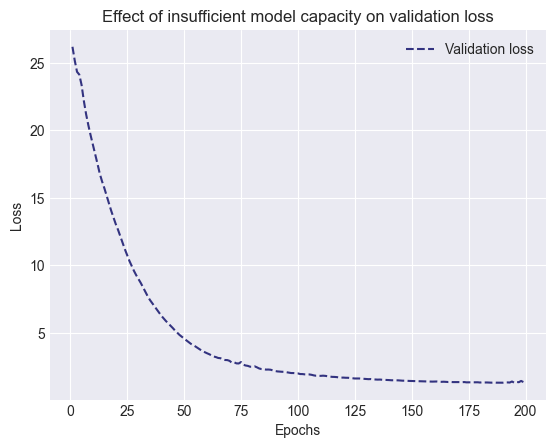

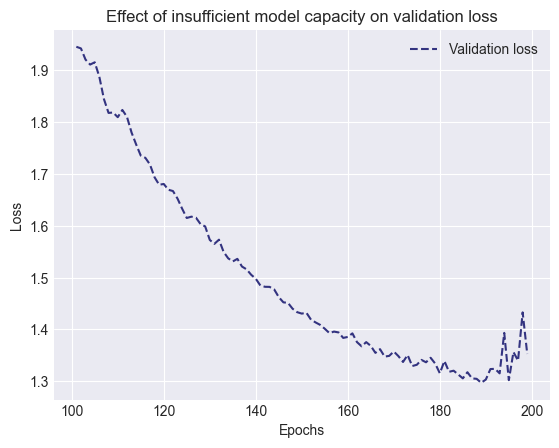

In [46]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, concatenate
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

lambda1 = 0.01
lambda2 = 0.01
lambda3 = 0.01
# 定義第一個LSTM模型
input_lstm_OCHLE = Input(shape=OCHLE_train.shape[1:])
hidden1_OCHLE = LSTM(300, return_sequences=True, activation='tanh', kernel_regularizer=l2(lambda1), \
                 recurrent_activation='sigmoid')(input_lstm_OCHLE)
hidden2_OCHLE = LSTM(300, activation='tanh', kernel_regularizer=l2(lambda1),\
                 recurrent_activation='sigmoid')(hidden1_OCHLE)
output_OCHLE = Dense(200, kernel_regularizer=l2(lambda1), activation='relu')(hidden2_OCHLE)

# 定義第二個LSTM模型
input_lstm_slope = Input(shape=X_train.shape[1:])
#lstm1 = LSTM(200, return_sequences=True, activation='relu')(input_slope)
hidden1_slope = LSTM(250, recurrent_activation='sigmoid', activation='tanh',return_sequences=True,\
                kernel_regularizer=l2(lambda2))(input_lstm_slope)
hidden2_slope = LSTM(250, activation='tanh', kernel_regularizer=l2(lambda2),\
                 recurrent_activation='sigmoid')(hidden1_slope)
output_slope = Dense(150, kernel_regularizer=l2(lambda2), activation='relu')(hidden2_slope)



# 合併兩個模型的輸出
#merged = concatenate([output_ann, dense_lstm], axis=-1)
merged = concatenate([output_OCHLE, output_slope], axis=-1)

# 加入一個Dense層
dense1 = Dense(600, activation='relu', kernel_regularizer=l2(lambda3))(merged)
dense2 = Dense(600, activation='relu', kernel_regularizer=l2(lambda3))(dense1)
# 最終輸出層
output = Dense(y_train.shape[1])(dense2)

# 定義模型
model = Model(inputs=[input_lstm_OCHLE, input_lstm_slope], outputs=output)


model.compile(loss='mse', optimizer = 'adam', metrics=['mse'])

# 顯示模型結構
#model.summary()

cum_epochs = 0
epochs = 1000
# 訓練模型
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, \
                               verbose=1, mode='min', restore_best_weights=True)
#hist_model = model.fit(
    #[OCHLE_train, X_train], y_train, epochs=epochs, batch_size=3000, \
    #validation_data=([OCHLE_val, X_val], y_val), callbacks=[early_stopping]
    #)
batch_size=3000
hist_model = model.fit(
    [OCHLE_train, X_train], y_train, epochs=epochs, batch_size=batch_size, \
    validation_split=0.2, callbacks=[early_stopping]
    )


val_loss = hist_model.history['val_loss']
cum_epochs = cum_epochs + len(val_loss)
plt.style.use('seaborn-darkgrid')

for i in [0, 100, 200, 300, 400, 450, 490]:
    if i >= len(val_loss):
        break
    else:
        plt.plot(range(i+1, cum_epochs+1, 1), val_loss[i:], ls='--', color=[0.2, 0.2, 0.5], \
                 label='Validation loss')
        plt.title('Effect of insufficient model capacity on validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


In [42]:
model_path = top_path
model_type = 'LSTM-LSTM'
forecast_variable = 'slope'
model_Dir_tree = ['Forecast&model', expiry, IV_type, 'K_{}'.format(K_Range_dir), \
                  'days_{}_{}'.format(seq_length1, seq_length2), model_type, forecast_variable]
for model_dir in model_Dir_tree:
    if model_dir not in os.listdir(model_path):
        os.mkdir(model_path + model_dir)
    model_path = model_path + model_dir + '/'

model_idx = 4
#while 'model{}.h5'.format(model_idx) in os.listdir(model_path):
    #model_idx + model_idx + 1
model_name = 'model{}'.format(model_idx)
model_file = 'model{}.h5'.format(model_idx)
model_png = 'model{}.png'.format(model_idx)
Forecast_name = 'model{}.csv'.format(model_idx)

#models = os.listdir
#test_loss = model.evaluate([OCHLE_test, X_test], y_test)
#print("Test Loss:", test_loss)
# 查看測試輸出
y_pred = model.predict([OCHLE_test, X_test])
y_pred = y_pred / magnification_slope
columns_names = ['履約價', '隱含波動率({})'.format(s_c)]
column_index = [IV_data.columns.get_loc(col) for col in columns_names]
ForecastIV = np.zeros(((len(y_pred), K_num)))
SSE_everyday = np.zeros(((len(y_pred), K_num)))
SSE_everyday_adj = np.zeros(((len(y_pred), K_num)))


for i in range(len(y_pred)):
    K_day = IV_matrix_test[i*K_num:(i+1)*K_num, column_index[0]]
    iv_day = IV_matrix_test[i*K_num:(i+1)*K_num, column_index[1]]
    y_pred_day = y_pred[i]
    iv_day_std = iv_day / np.std(iv_day, ddof=1)
    y_pred_day_adj = y_pred_day / np.std(iv_day, ddof=1)
    ForecastIV[i], SSE_everyday[i] = minSSE_recovery(y=iv_day, x=K_day, slope_yhat=y_pred_day)
    ForecastIV_day_adj, SSE_everyday_adj[i] = minSSE_recovery(y=iv_day_std, x=K_day, slope_yhat=y_pred_day_adj)
    

ForecastIV = np.reshape(ForecastIV,(-1,1))
sse_everyday = SSE_everyday[:, 0]
sse_everyday_adj = SSE_everyday_adj[:, 0]
SSE_everyday = np.reshape(SSE_everyday ,(-1,1))
SSE_everyday_adj = np.reshape(SSE_everyday_adj ,(-1,1))
Forecast_matrix  = np.hstack((IV_matrix_test, ForecastIV, SSE_everyday, SSE_everyday_adj))
column = np.hstack((IV_data.columns.to_numpy(), np.array(['預測隱含波動率({})'.format(s_c), 'loss', '調整後loss'])))
Forecast_Data = pd.DataFrame(data=Forecast_matrix, columns=column)


loss_columns_names = ['交易日期', '到期天數', 'loss']
loss_columns_index = [Forecast_Data.columns.get_loc(col) for col in loss_columns_names]
loss_Data = Forecast_Data.iloc[range(0, len(Forecast_Data), K_num), loss_columns_index]
loss_Data = loss_Data.reset_index().iloc[:,1:]
loss_Data = loss_Data.rename(columns={'loss': model_name})
MSE_data = pd.DataFrame(columns=loss_Data.columns, data=[['MSE', 'MSE', np.mean(sse_everyday)]])
loss_Data = pd.concat([loss_Data, MSE_data], axis=0)
loss_Data = loss_Data.reset_index().iloc[:,1:]
print(np.mean(sse_everyday))

#-----------------------------------------------

loss_adj_columns_names = ['交易日期', '到期天數', '調整後loss']
loss_adj_columns_index = [Forecast_Data.columns.get_loc(col) for col in loss_adj_columns_names]
loss_adj_Data = Forecast_Data.iloc[range(0, len(Forecast_Data), K_num), loss_adj_columns_index]
loss_adj_Data = loss_adj_Data.reset_index().iloc[:,1:]
loss_adj_Data = loss_adj_Data.rename(columns={'調整後loss': model_name})
MSE_adj_data = pd.DataFrame(columns=loss_adj_Data.columns, data=[['MSE', 'MSE', np.mean(sse_everyday_adj)]])
loss_adj_Data = pd.concat([loss_adj_Data, MSE_adj_data], axis=0)
loss_adj_Data = loss_adj_Data.reset_index().iloc[:,1:]


from tensorflow.keras.utils import plot_model
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

if 'Modelloss.csv' in os.listdir(model_path):
    Modelloss = pd.read_csv(model_path + 'Modelloss.csv', index_col=False, encoding='Big5')
    Modelloss_adj = pd.read_csv(model_path + 'Modelloss_adj.csv', index_col=False, encoding='Big5')
    if model_name in Modelloss.columns:
        if Modelloss[model_name][len(Modelloss)-1] > np.mean(sse_everyday):
            Modelloss[model_name] = loss_Data[model_name]
            Modelloss_adj[model_name] = loss_adj_Data[model_name]
            Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
            model.save(model_path + model_file)
            plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)
            print('原本的{}已經被替換'.format(model_name))
        else:
            print('此模型未被儲存')
    elif len(Modelloss.columns) >= 22 :
        all_MSE = np.array(Modelloss.iloc[-1, 2:])
        max_MSE = np.max(all_MSE)
        if max_MSE > np.mean(sse_everyday):
            max_MSE_idx = (np.arange(len(all_MSE))[np.equal(all_MSE, max_MSE)])[0] +2
            Modelloss.iloc[:,max_MSE_idx] = loss_Data[model_name]
            Modelloss_adj.iloc[:,max_MSE_idx] = loss_adj_Data[model_name]
            model_name = Modelloss.columns[max_MSE_idx]
            Forecast_name = model_name + '.csv'
            model_file = model_name + '.h5'
            model_png = model_name + '.png'
            Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
            model.save(model_path + model_file)
            plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)
            print('原本的{}已經被替換'.format(model_name))
        else:
            print('此模型未被儲存')
    else:
        Modelloss = pd.concat([Modelloss, loss_Data[model_name]], axis=1)
        Modelloss = Modelloss.reset_index().iloc[:,1:] 
        Modelloss_adj = pd.concat([Modelloss_adj, loss_Data[model_name]], axis=1)
        Modelloss_adj = Modelloss_adj.reset_index().iloc[:,1:] 
        Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
        model.save(model_path + model_file)
        plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)
        print('此模型已經被儲存為{}'.format(model_name))
else:
    Modelloss = loss_Data
    Modelloss_adj = loss_adj_Data
    Forecast_Data.to_csv(model_path + Forecast_name, index=False, encoding='Big5')
    model.save(model_path + model_file)
    plot_model(model, to_file=model_path + model_png, show_shapes=True, show_layer_names=True)

    
Modelloss.to_csv(model_path + 'Modelloss.csv', index=False, encoding='Big5')
Modelloss_adj.to_csv(model_path + 'Modelloss_adj.csv', index=False, encoding='Big5')

13/13 [==============================] - 1s 14ms/step
0.00360072289999682
此模型未被儲存


In [20]:
columns_names = ['履約價', '隱含波動率({})'.format(s_c)]
column_index = [IV_data.columns.get_loc(col) for col in columns_names]
ForecastIV = np.zeros(((len(y_pred), K_num)))



for i in range(len(y_pred)):
    x = IV_matrix_test[i*K_num:(i+1)*K_num, column_index[0]]
    v0 = IV_matrix_test[i*K_num, column_index[1]]
    ForecastIV[i] = recovery_curve(x, y_pred[i]/(magnification_slope), y0=v0)
ForecastIV = np.reshape(ForecastIV,(-1,1))
Forecast_matrix  = np.hstack((IV_matrix_test, ForecastIV))
column = np.hstack((IV_data.columns.to_numpy(), np.array(['預測隱含波動率({})'.format(s_c)])))
Forecast_Data = pd.DataFrame(data=Forecast_matrix, columns=column)


Forecast_Data.to_csv(current_path + 'slope_30.csv', index=False, encoding='Big5')

In [1]:
from scipy.stats import norm

z = norm.rvs(loc=0, scale=0.2, size=9)

In [2]:
import numpy as np
w = np.linspace(-2*np.pi, 2*np.pi, 10)
x = np.sin(w)
sx = Slope(X=w, Y=x, axis=0)
sx = sx+z
plt.plot(w, x)

x_sum = x.sum()
x0 = x[:-1]
x1 = x[1:]

y = recovery_curve(w, sx, y0=0)
plt.plot(w, y)

print(x)
print(y)

NameError: name 'Slope' is not defined